In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

# SSRT by SSD

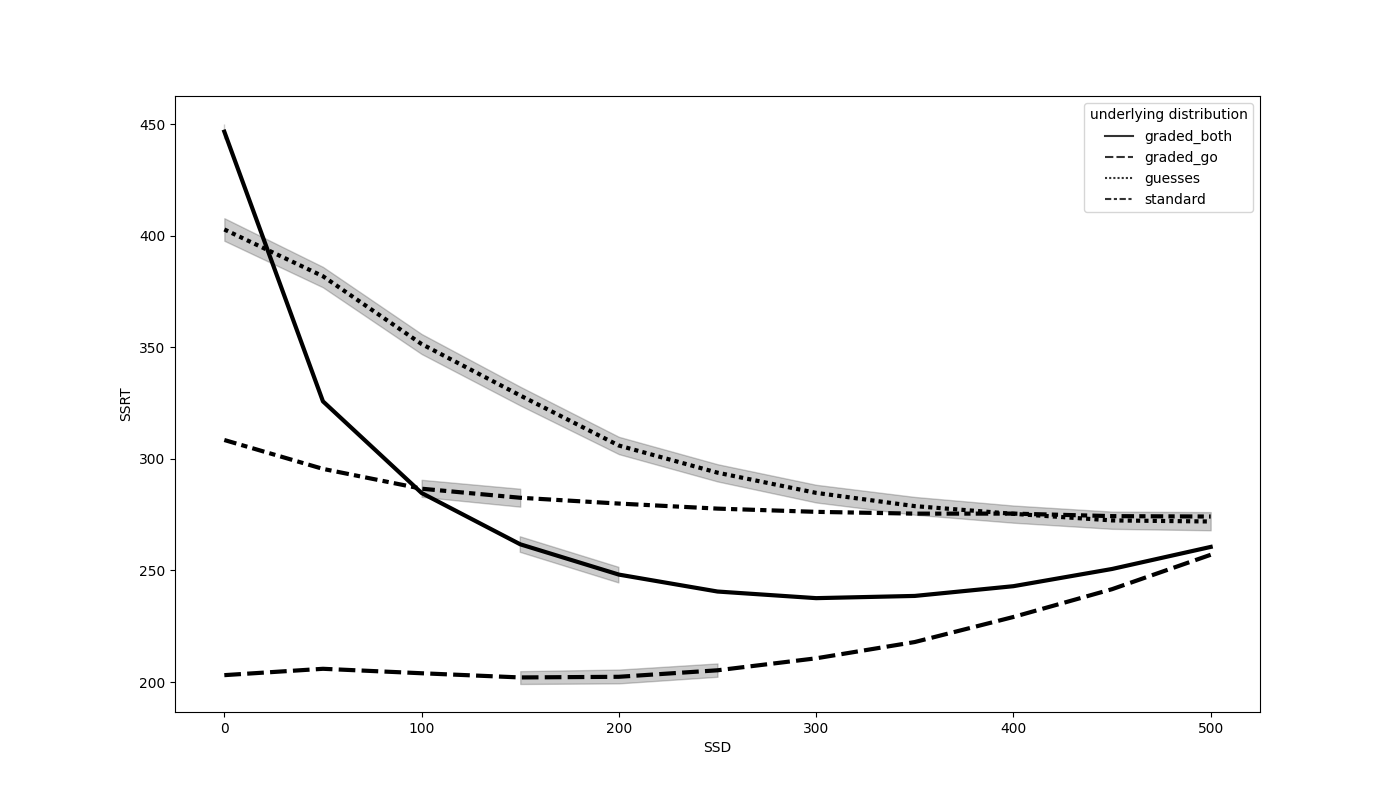

In [2]:
Image('figures/SSRT_by_SSD.png')

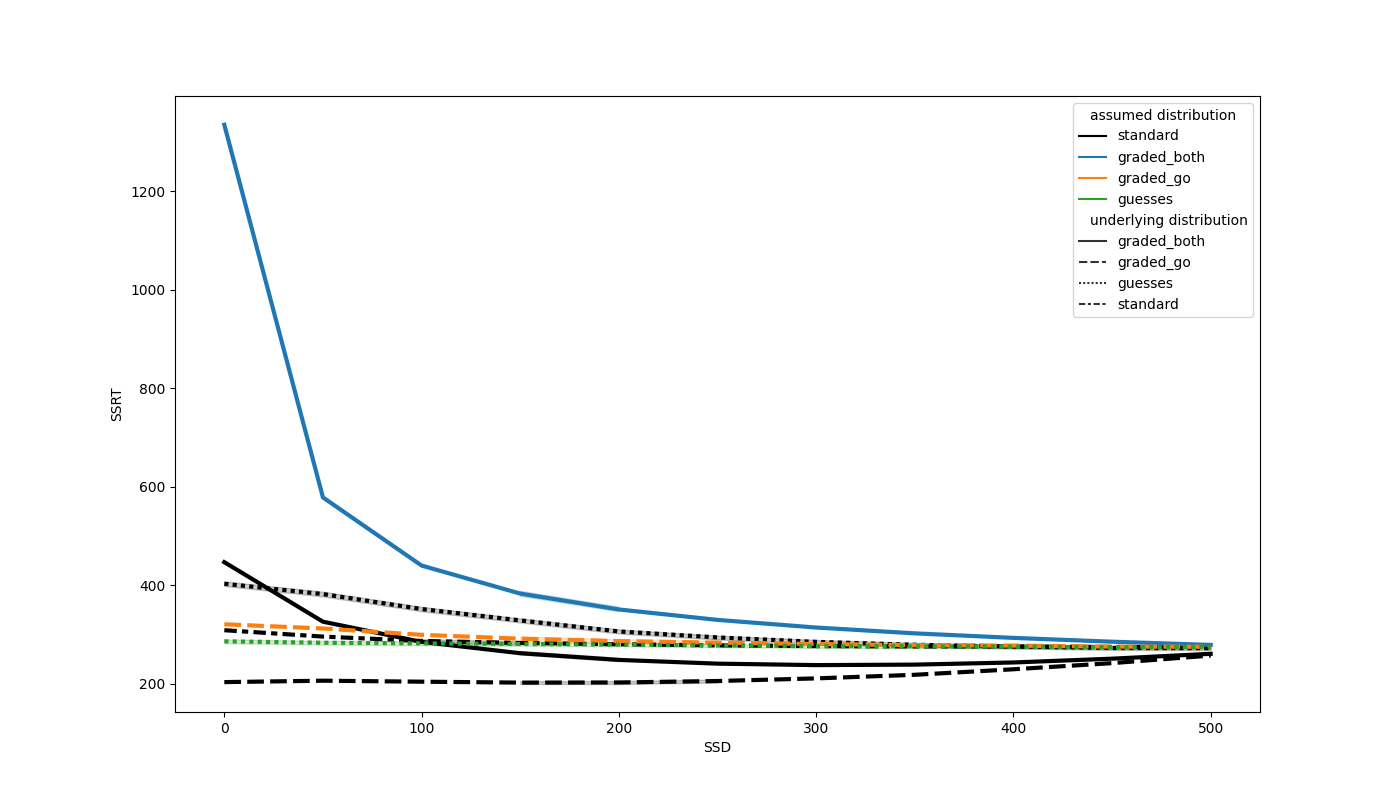

In [3]:
Image('figures/SSRT_by_SSD_supplement.png')

# Inhibition Function

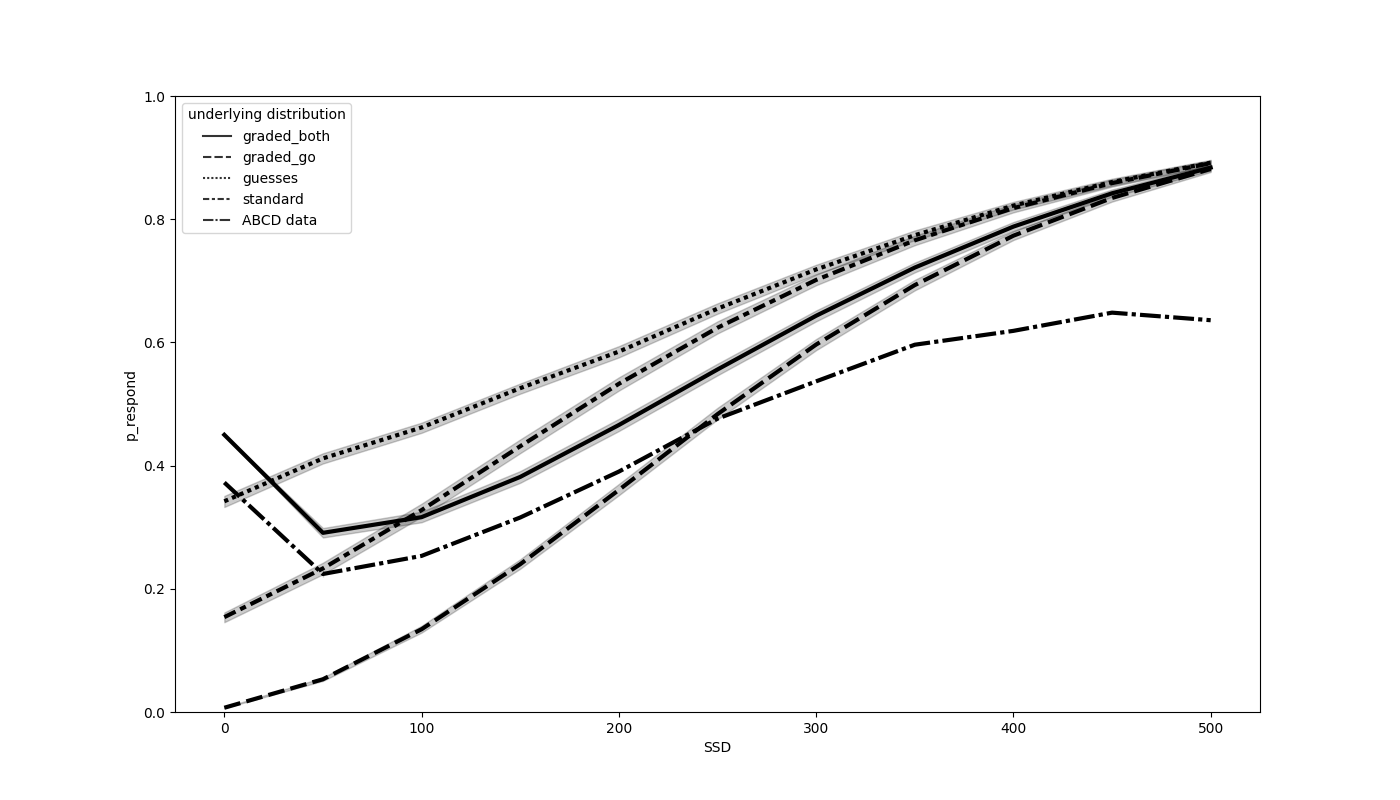

In [4]:
Image('figures/inhibition_function.png')

# Individual Differences

In [5]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [6]:
df = pd.read_csv('ssrt_metrics/expected_ssrts.csv', index_col=0)

# reformatting - was multiindex
df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(df.loc['underlying distribution', :].values, df.columns)]
df = df.drop(['underlying distribution', 'NARGUID'])

for col in df.columns:
    df[col] = df[col].astype(float)


In [7]:
sim_rt_info = pd.read_csv('simulated_data/sim_rt_meanStd.csv', index_col = 0)

In [8]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus.json'
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [9]:
mus_df.head()

,goRT,go,SSRT,stop
003RTV85,575.295505,0.190369,158.731993,0.919693
007W6H7B,453.614919,0.247761,222.859696,0.578504
00CY2MDM,617.052023,0.176351,269.084639,0.456445
00HEV6HB,546.564175,0.201384,158.648178,0.920402
00J52GPG,577.825255,0.189457,269.611172,0.455350


In [10]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), sim_rt_info, df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [11]:
monster_df

,assigned_goRT,assigned_go,assigned_SSRT,assigned_stop,sim_rt_mean,sim_rt_std,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard,...,gen-guesses_SSRT-graded_both,gen-standard_SSRT-graded_both,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
00J52GPG,577.825255,0.189457,269.611172,0.455350,537.5210,216.061634,368.266667,195.133333,371.033333,273.266667,...,743.650000,466.983333,266.0,202.0,322.0,265.0,231.358,196.096,307.554,259.890
00LJVZK2,553.090324,0.198771,327.624670,0.360199,512.0010,196.643602,319.698113,226.566038,356.283019,309.981132,...,647.245283,492.811321,297.0,222.0,357.0,308.0,285.538,220.704,377.406,299.922
00R4TXET,571.954323,0.191588,270.609742,0.453289,529.3815,207.965889,250.200000,199.483333,300.550000,260.216667,...,437.333333,367.200000,259.0,205.0,327.0,266.0,229.340,192.452,321.760,263.620
028WCTG6,592.259351,0.184414,300.324551,0.399481,544.3005,218.878764,278.666667,210.383333,332.883333,286.483333,...,477.916667,403.633333,294.0,218.0,349.0,287.0,261.590,214.000,358.610,280.974
029PWCFY,555.882290,0.197674,339.270525,0.345697,516.4205,196.747987,313.983333,228.050000,364.816667,316.383333,...,617.216667,501.583333,306.0,234.0,368.0,312.0,299.410,226.858,386.978,310.766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUXHPX3N,509.326761,0.217710,267.266361,0.460265,481.6645,182.295748,220.716667,196.900000,263.283333,253.316667,...,347.366667,330.116667,253.0,191.0,301.0,261.0,228.164,184.008,296.992,253.956
ZWWDT1TG,690.135552,0.156217,322.465029,0.367020,620.1270,271.202340,280.375000,250.732143,335.410714,302.928571,...,426.196429,379.517857,320.0,243.0,406.0,311.0,283.078,251.118,388.600,298.430
ZXF5C635,492.856640,0.225807,390.884096,0.293355,466.2770,167.058153,302.133333,261.250000,340.566667,348.050000,...,468.616667,456.616667,317.0,244.0,367.0,348.0,337.958,243.428,400.290,351.194
ZXPAWB32,485.968058,0.229375,308.828788,0.386356,460.1125,169.012844,239.793103,223.344828,275.724138,289.000000,...,354.258621,359.275862,269.0,204.0,308.0,288.0,273.762,202.068,328.862,287.278


In [12]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

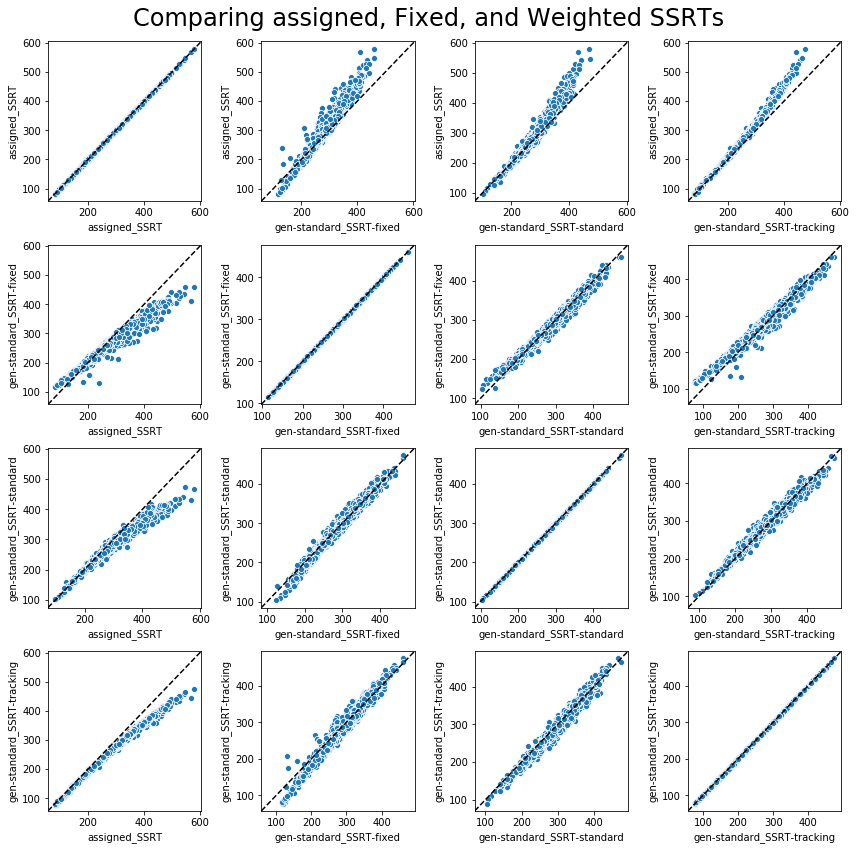

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [14]:
monster_df[columns].corr(method='spearman')

,assigned_SSRT,gen-standard_SSRT-fixed,gen-standard_SSRT-standard,gen-standard_SSRT-tracking
assigned_SSRT,1.000000,0.979367,0.987431,0.997825
gen-standard_SSRT-fixed,0.979367,1.000000,0.989543,0.982831
gen-standard_SSRT-standard,0.987431,0.989543,1.000000,0.987674
gen-standard_SSRT-tracking,0.997825,0.982831,0.987674,1.000000


# Comparing Fixed SSRTs

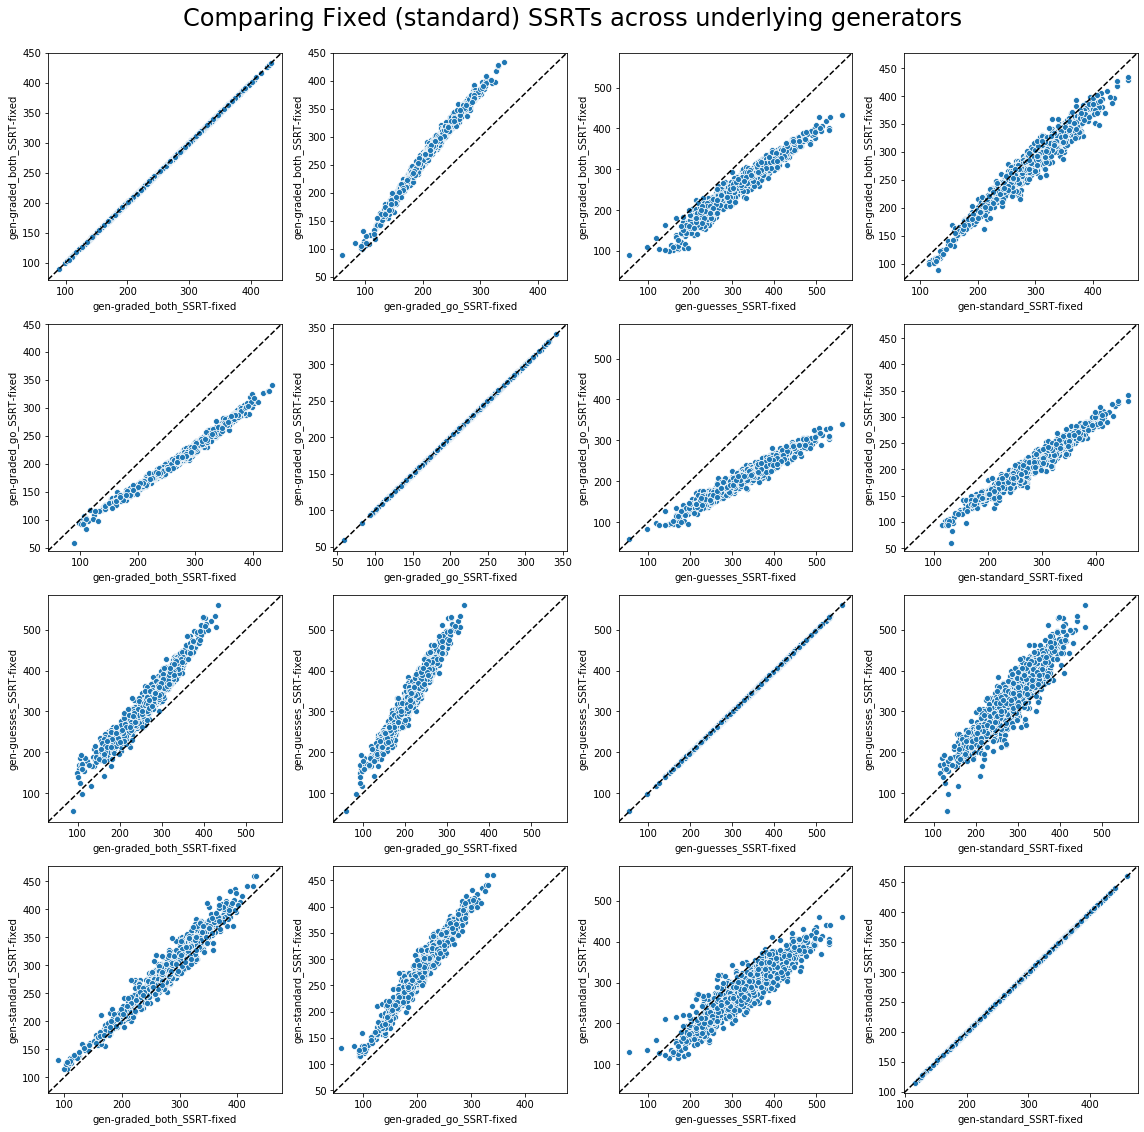

In [15]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [16]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed
gen-graded_both_SSRT-fixed,1.000000,0.994725,0.972080,0.972695
gen-graded_go_SSRT-fixed,0.994725,1.000000,0.969253,0.974891
gen-guesses_SSRT-fixed,0.972080,0.969253,1.000000,0.905374
gen-standard_SSRT-fixed,0.972695,0.974891,0.905374,1.000000


## (not rescaling the axes to get a closer look)

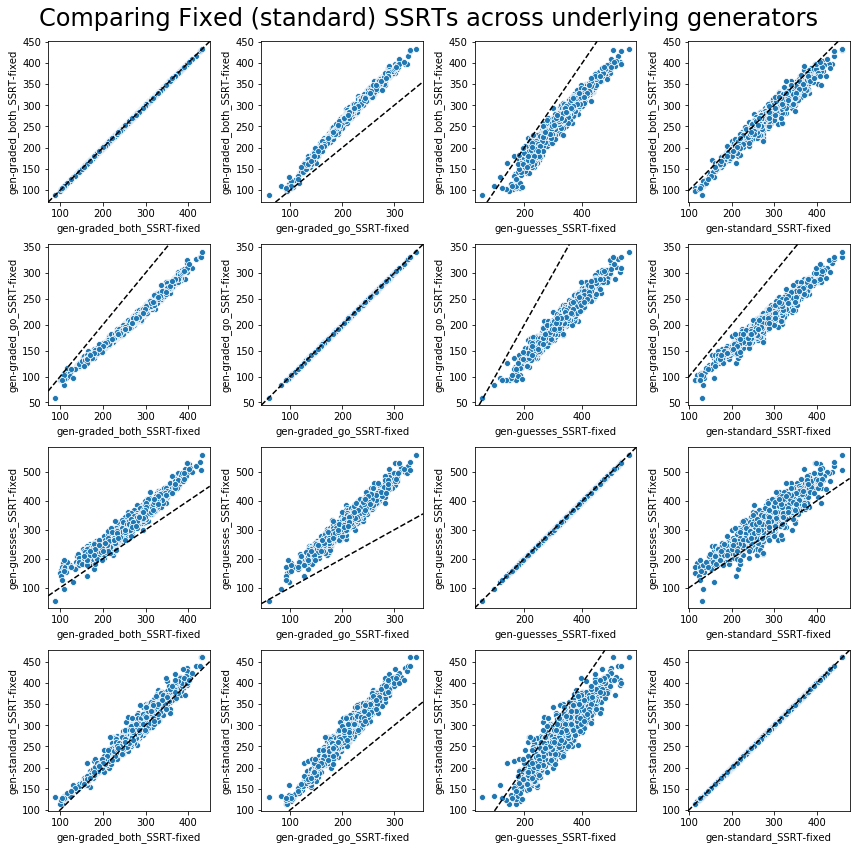

In [17]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

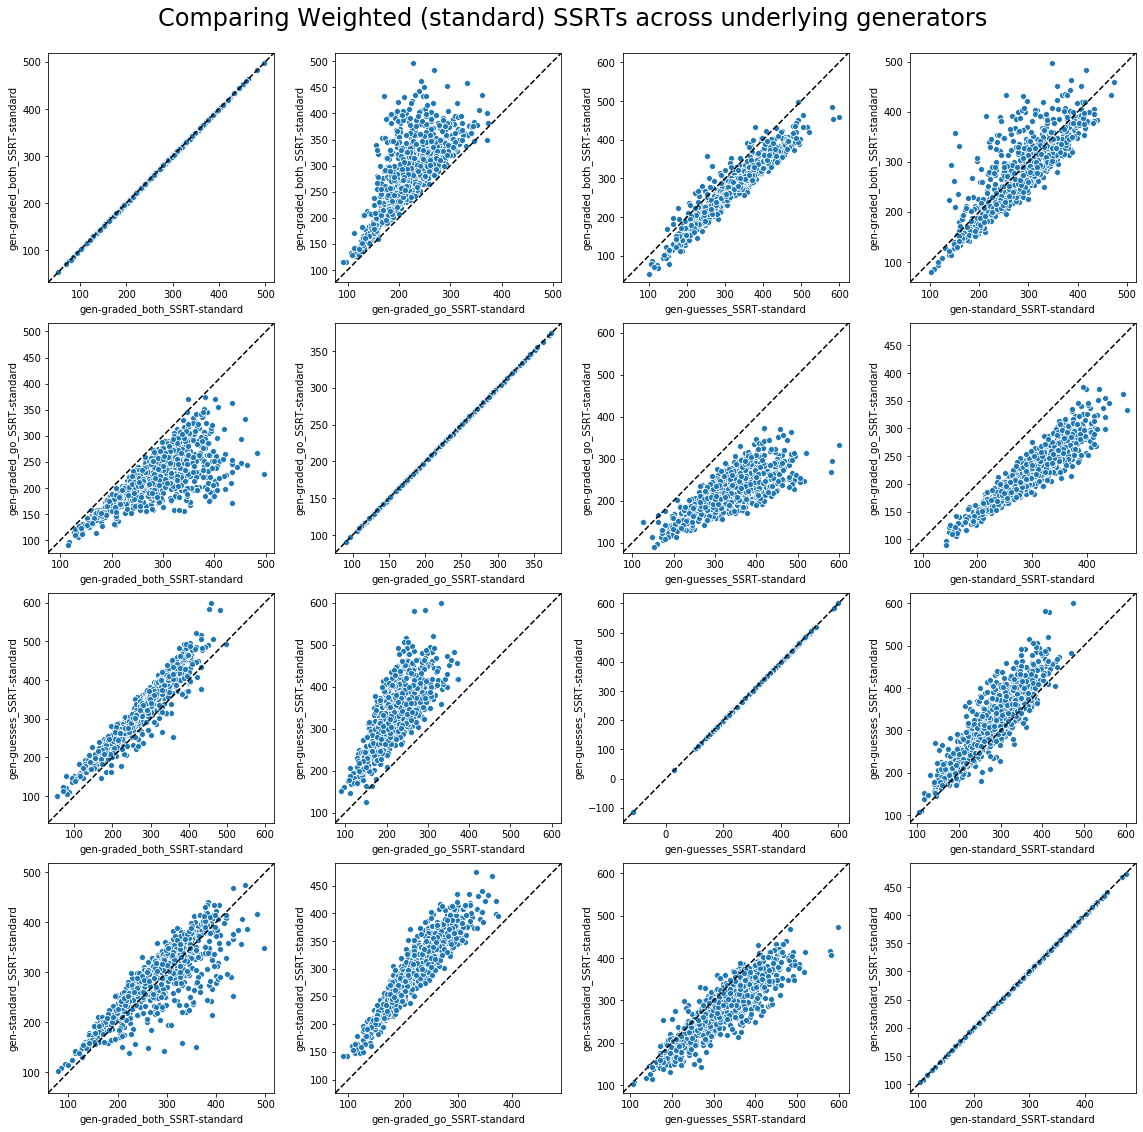

In [18]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [19]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard
gen-graded_both_SSRT-standard,1.000000,0.756176,0.956194,0.849430
gen-graded_go_SSRT-standard,0.756176,1.000000,0.792675,0.935123
gen-guesses_SSRT-standard,0.956194,0.792675,1.000000,0.879522
gen-standard_SSRT-standard,0.849430,0.935123,0.879522,1.000000


## not rescaling axis to get a closer look

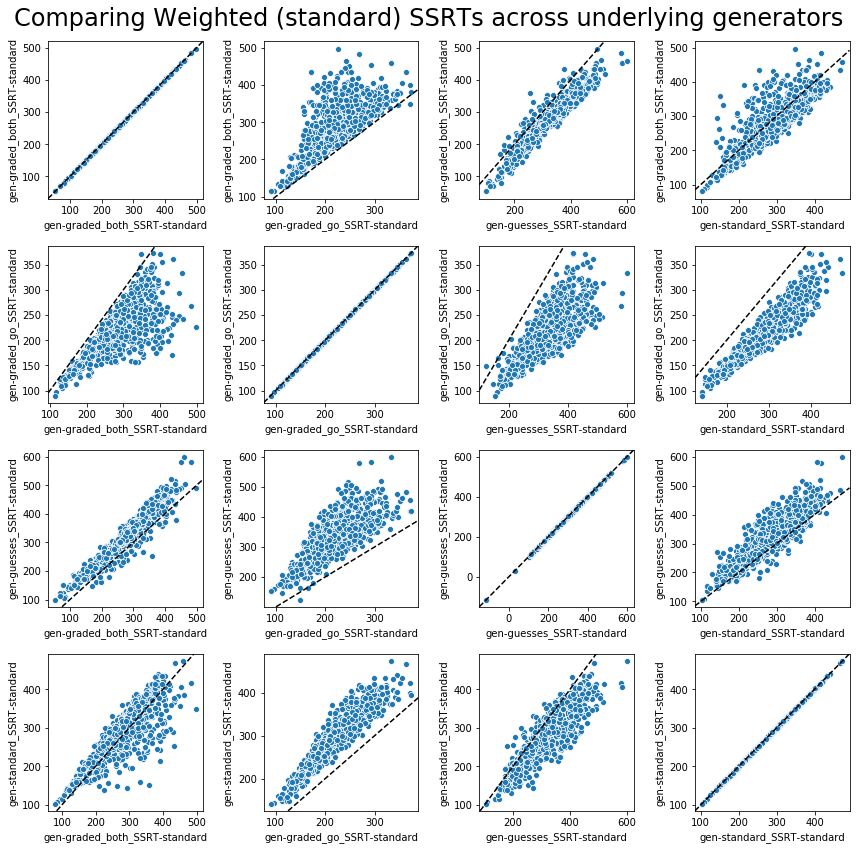

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

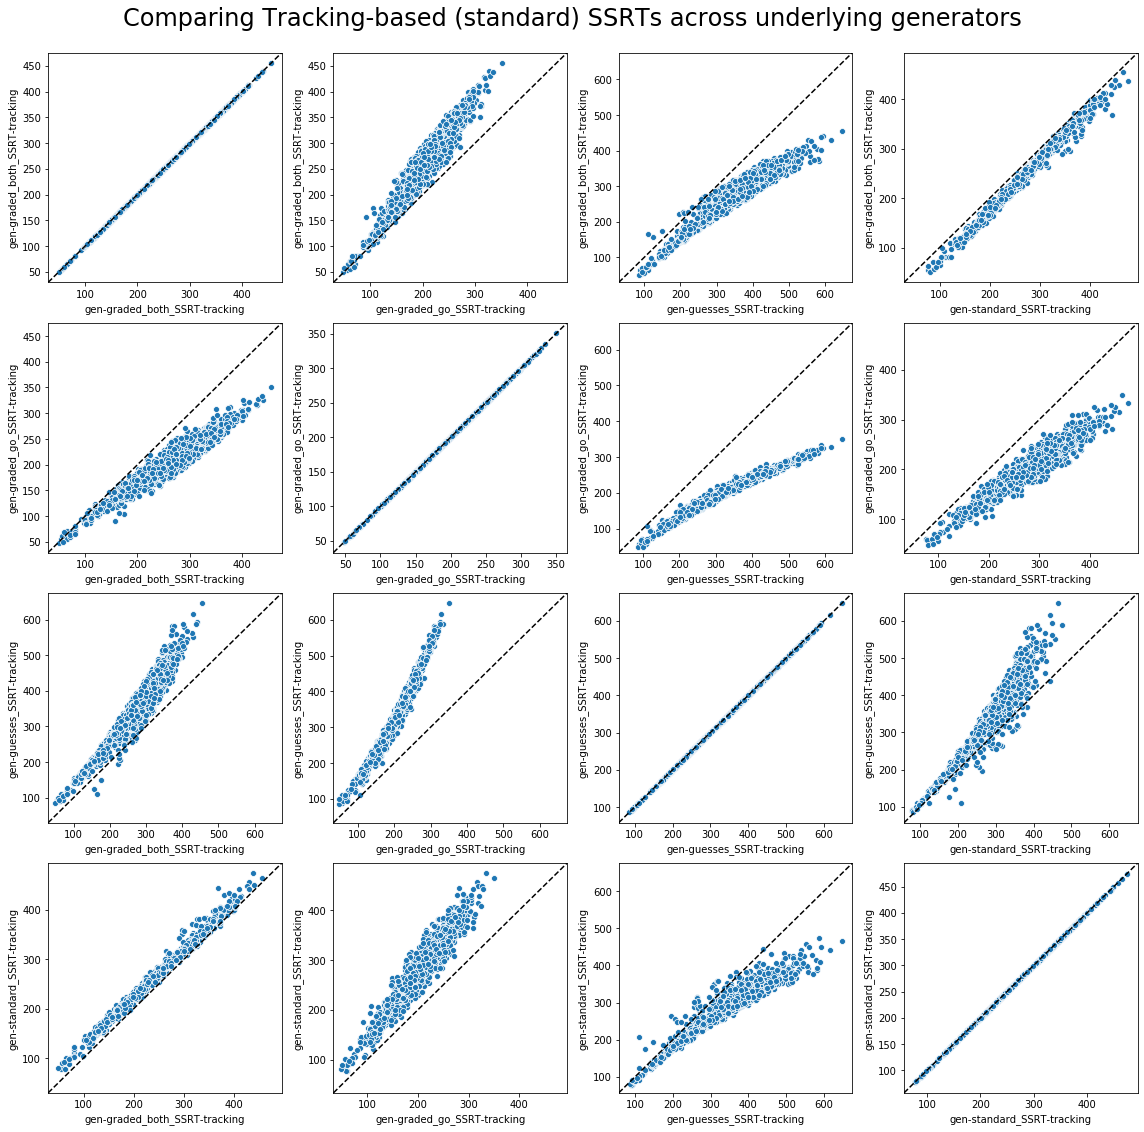

In [21]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [22]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
gen-graded_both_SSRT-tracking,1.000000,0.951466,0.958235,0.994440
gen-graded_go_SSRT-tracking,0.951466,1.000000,0.987289,0.947622
gen-guesses_SSRT-tracking,0.958235,0.987289,1.000000,0.952696
gen-standard_SSRT-tracking,0.994440,0.947622,0.952696,1.000000


## not rescaling axes

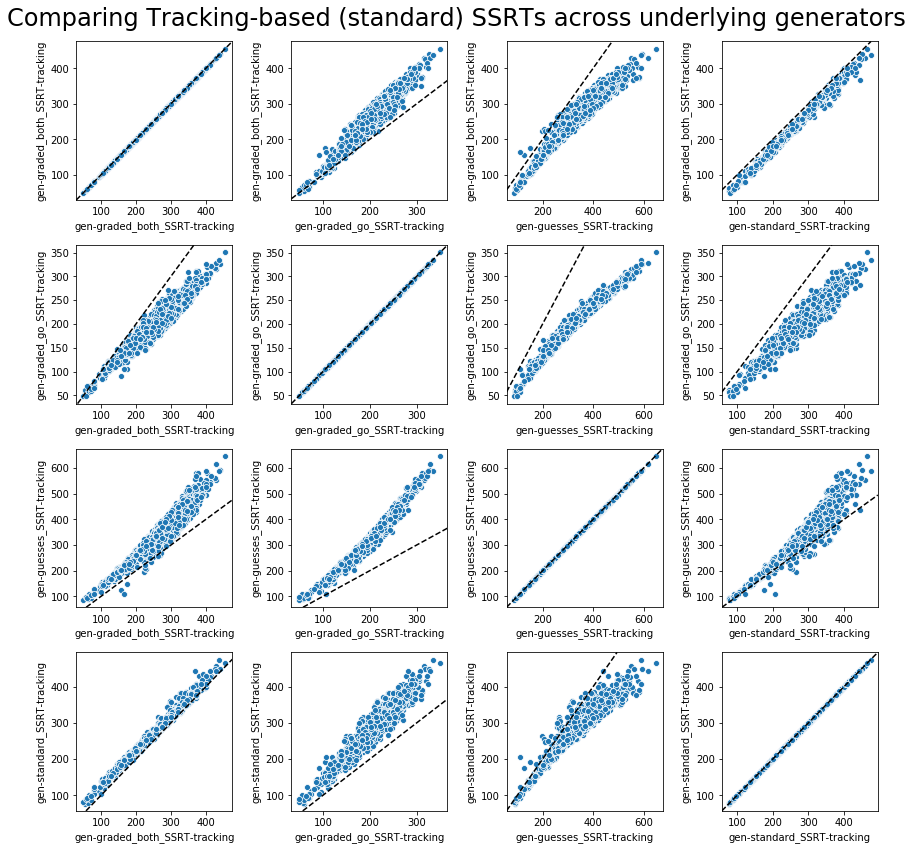

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [24]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

,assigned_SSRT,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
count,1152.000000,1144.000000,1058.000000,1152.000000,1122.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,300.469137,272.410977,218.139674,315.277868,285.054462,270.914931,209.927083,329.494792,282.168403,255.543054,201.901519,330.216458,277.415424
std,82.655659,68.531261,46.933290,77.179215,62.742139,59.474192,43.823375,73.998943,61.574401,72.965514,50.925583,96.640753,69.330866
min,81.863528,53.516667,90.283333,-115.000000,103.000000,89.000000,59.000000,55.000000,115.000000,49.578000,48.094000,85.672000,76.924000
25%,247.436543,226.195833,185.556863,265.062500,244.487500,233.000000,180.000000,280.000000,243.000000,208.604500,169.651000,265.592500,232.645500
50%,298.628988,274.631250,215.508333,316.225000,286.508333,274.000000,210.000000,332.000000,283.000000,257.613000,203.734000,327.658000,278.830000
75%,355.835903,318.900000,249.962500,365.783333,329.225000,313.000000,240.000000,378.000000,325.000000,309.140500,237.116000,396.677000,326.424000
max,579.543226,497.333333,373.980392,599.633333,473.700000,433.000000,341.000000,560.000000,460.000000,455.188000,350.436000,646.944000,474.662000


In [25]:
df.corr(method='spearman')

,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard.1,gen-guesses_SSRT-standard.2,gen-standard_SSRT-standard.3,gen-graded_both_SSRT-guesses,gen-graded_go_SSRT-guesses.1,gen-guesses_SSRT-guesses.2,gen-standard_SSRT-guesses.3,gen-graded_both_SSRT-graded_go,gen-graded_go_SSRT-graded_go.1,...,gen-guesses_SSRT-graded_both.2,gen-standard_SSRT-graded_both.3,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed.1,gen-guesses_SSRT-fixed.2,gen-standard_SSRT-fixed.3,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking.1,gen-guesses_SSRT-tracking.2,gen-standard_SSRT-tracking.3
gen-graded_both_SSRT-standard,1.000000,0.756176,0.956194,0.849430,0.824569,0.247733,0.818519,0.511873,0.875740,0.840761,...,0.915949,0.860303,0.835891,0.832649,0.806768,0.824402,0.797573,0.833720,0.826041,0.793691
gen-graded_go_SSRT-standard.1,0.756176,1.000000,0.792675,0.935123,0.851974,0.767423,0.940312,0.822599,0.476766,0.924702,...,0.519207,0.677093,0.955944,0.962403,0.892429,0.969368,0.944958,0.965389,0.963775,0.942298
gen-guesses_SSRT-standard.2,0.956194,0.792675,1.000000,0.879522,0.770001,0.264219,0.851088,0.527461,0.777800,0.845817,...,0.882962,0.837647,0.912646,0.910435,0.910581,0.876612,0.831815,0.904437,0.894558,0.823045
gen-standard_SSRT-standard.3,0.849430,0.935123,0.879522,1.000000,0.937361,0.633010,0.992951,0.851008,0.638081,0.992438,...,0.716903,0.892008,0.947075,0.949510,0.862307,0.989543,0.986447,0.961808,0.967086,0.987674
gen-graded_both_SSRT-guesses,0.824569,0.851974,0.770001,0.937361,1.000000,0.649603,0.933157,0.862470,0.654215,0.931712,...,0.684281,0.877693,0.827900,0.829734,0.713115,0.902318,0.932789,0.852100,0.860463,0.935800
gen-graded_go_SSRT-guesses.1,0.247733,0.767423,0.264219,0.633010,0.649603,1.000000,0.676937,0.895015,-0.033715,0.630755,...,-0.030358,0.297394,0.598490,0.607744,0.491733,0.677672,0.709709,0.626507,0.637140,0.715149
gen-guesses_SSRT-guesses.2,0.818519,0.940312,0.851088,0.992951,0.933157,0.676937,1.000000,0.879059,0.591023,0.992383,...,0.687241,0.874383,0.936228,0.939273,0.848777,0.985181,0.990721,0.955818,0.959299,0.993717
gen-standard_SSRT-guesses.3,0.511873,0.822599,0.527461,0.851008,0.862470,0.895015,0.879059,1.000000,0.295642,0.836809,...,0.345529,0.685059,0.744190,0.750671,0.605899,0.850967,0.899135,0.777756,0.795132,0.903922
gen-graded_both_SSRT-graded_go,0.875740,0.476766,0.777800,0.638081,0.654215,-0.033715,0.591023,0.295642,1.000000,0.678594,...,0.956072,0.831344,0.546497,0.545438,0.502610,0.564346,0.562555,0.552953,0.551484,0.562256
gen-graded_go_SSRT-graded_go.1,0.840761,0.924702,0.845817,0.992438,0.931712,0.630755,0.992383,0.836809,0.678594,1.000000,...,0.711661,0.885644,0.919612,0.925026,0.813436,0.978231,0.985338,0.941702,0.947188,0.987461


In [26]:
# monster_df[main_cols].loc[monster_df['gen-graded_both_SSRT-standard'].notnull()].to_csv('simulation_mainSSRTs_scale0.csv')
len(monster_df[main_cols].loc[monster_df['gen-graded_both_SSRT-standard'].notnull()])

1144

# Plot graded Mu Go function

In [27]:
SSDs = np.arange(0,650, 5)

simulator = SimulateData()
mu_gos = [[i, simulator._log_grade_mu(1, i)] for i in SSDs]

/Users/henrymj/Documents/ABCD_simulations/scripts/utils.py:342: RuntimeWarning: divide by zero encountered in log
  return self._at_least_0((np.log(SSD/max_SSD)/4+1) * mu_go)


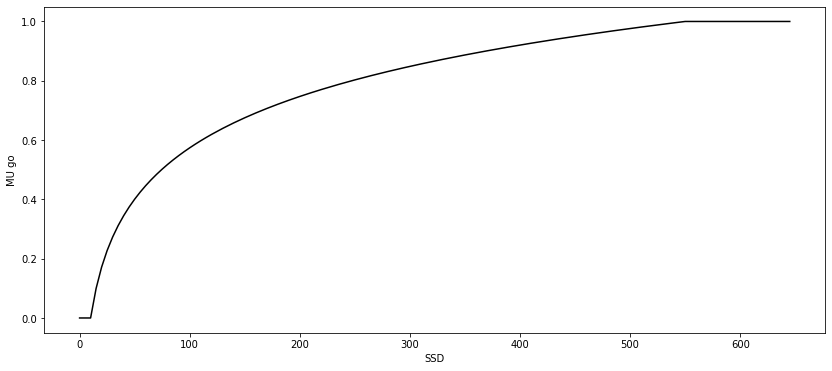

In [28]:
fig,ax = plt.subplots(1,1, figsize=(14, 6))

_ = sns.lineplot(x='SSD', y='MU go', color='k', data=pd.DataFrame(mu_gos, columns=['SSD', 'MU go']))
plt.savefig('figures/graded_mu_go_function.png')

In [29]:
monster_df.index.unique()

Index(['00J52GPG', '00LJVZK2', '00R4TXET', '028WCTG6', '029PWCFY', '030W95VP',
       '03VJZEL', '040B4TRC', '04BFG4JM', '052HU3CU',
       ...
       'ZRR4D9LW', 'ZTN5R70A', 'ZTP2ZHLN', 'ZTTGYL51', 'ZUDPGDWJ', 'ZUXHPX3N',
       'ZWWDT1TG', 'ZXF5C635', 'ZXPAWB32', 'ZYF317MG'],
      dtype='object', length=1152)